In [4]:
import gymnasium as gym
import numpy as np
import os
import csv
import torch
import sardine
import re
import argparse
import datetime
from agents.wrappers import IdealState
from pymoo.indicators.hv import HV
from distutils.util import strtobool

In [9]:
def parse_args():
    parser = argparse.ArgumentParser(description="Environment Evaluation")
    parser.add_argument("--morl", type=lambda x: bool(strtobool(x)), default=False, help="Specify if the algorithm is multi-objective.")
    parser.add_argument("--env-ids", type=str, nargs='+', default=["sardine/SlateTopK-Bored-v0"], help="List of environment IDs.")
    parser.add_argument("--methods", type=str, nargs='+', default=["random"], help="List of methods to evaluate.")
    parser.add_argument("--seeds", type=int, nargs='+', default=[2705, 3751, 4685, 3688, 6383], help="List of seeds for reproducibility.")
    parser.add_argument("--n-val-episodes", type=int, default=200, help="Number of validation episodes.")
    parser.add_argument("--total-timesteps", type=int, default=10000, help="Total timesteps for the evaluation.")
    parser.add_argument("--val-interval", type=int, default=100, help="Interval between validation steps.")
    parser.add_argument("--log-dir", type=str, default="logs", help="Directory to save logs.")
    parser.add_argument("--slate-size", type=int, default=10, help="Size of the slate.")
    
    return parser.parse_args()

# create a dict with parse args stored in a dict

args_dict = {"morl": False, "env-ids": ["sardine/SlateTopK-Bored-v0"], "methods": ["random","greedyoracle"], "seeds": [2705, 3751, 4685, 3688, 6383], "n-val-episodes": 25, "total-timesteps": 10000, "val-interval": 100, "log-dir": "logs", "slate-size": 10}

def log_data(method, steps, returns, log_dir):
    """
    Logs the method returns data into a CSV file.
    """
    os.makedirs(log_dir, exist_ok=True)
    filename = os.path.join(log_dir, f"{method}_returns.csv")
    
    with open(filename, "w", newline="") as csvfile:
        csvwriter = csv.writer(csvfile)
        # Writing header
        csvwriter.writerow(["steps", "return"])
        # Writing data
        for step, ret in zip(steps, returns):
            csvwriter.writerow([step, ret])

In [10]:
start = datetime.datetime.now()


slate_list = [3,5,10,20]
num_items = [500,100, 1000]
num_dict = {}
for num_item in num_items:
    slate_dict = {}
    for slate_size in slate_list:
        for env_id in args_dict["env-ids"]:
            # Make the environment
            env_embedds = None
            env = gym.make(env_id, slate_size=slate_size, morl=args_dict["morl"], num_items = num_item, env_embedds=f"item_embeddings_numitems{num_item}.npy")
            env_name = "-".join(env_id.lower().split("-")[:-1])

            env_dict = {}
            for method in args_dict["methods"]:
                print(f"\nRunning {method} on {env_id} with {num_item} items and slate size {slate_size}")

                click_list = []
                diversity_list = []
                hypervolume_list = []
                catalog_coverage_list = []  # New list to track catalog coverage
                num_users = 0
                val_returns_all = []
                seed_dict = {}

                methods_dict = {}
                for seed in args_dict["seeds"]:
                    info_dict = {}
                    # CSV logger
                    csv_filename = f"run_{env_name}-{method}-0-{seed}"
                    csv_filename = re.sub(r"[^a-zA-Z0-9]+", '-', csv_filename)
                    csv_path = os.path.join(args_dict["log-dir"], "baselines", csv_filename + ".log")
                    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
                    csv_file = open(csv_path, "w+", newline="")
                    csv_writer = csv.writer(csv_file)
                    csv_writer.writerow(["field", "value", "step"])

                    # Environment initialization
                    observation, info = env.reset(seed=seed)
                    env.action_space.seed(seed)

                    # Run the agent on the environment
                    val_returns, val_diversity, val_catalog_coverage = [], [], []
                    seed_clicks = []
                    seed_catalog_coverage = []
                    
                    val_metrics = []
                    for _ in range(args_dict["n-val-episodes"]):
                        cum_reward = 0
                        cum_boredom = 0
                        terminated, truncated = False, False
                        num_users += 1
                        diversity = 0

                        val_reward_list = []
                        catalog_coverage = []
                        val_diversity_list = []
                        while not (terminated or truncated):
                            action = None

                            if method == "greedyoracle":  # Greedy oracle
                                action = -np.ones(env.unwrapped.slate_size, dtype=int)
                            elif method == "random":  # Random slate
                                action = torch.randint(low=0, high=env.unwrapped.num_items, size=(env.unwrapped.slate_size,)).numpy()
                            else: 
                                raise ValueError(f"Unknown method: {method}")
                            observation, reward, terminated, truncated, info = env.step(action)
                            cum_reward += reward
                            cum_boredom += (1.0 if np.sum(info.get("bored", False)) > 0 else 0.0)
                            diversity += info["diversity"]

                            val_reward_list.append(reward)
                            val_diversity_list.append(info["diversity"])
                            catalog_coverage.append(info["catalog_coverage"])  # Track catalog coverage

                            if terminated or truncated:
                                val_metrics.append({"clicks": val_reward_list, "diversity": val_diversity_list, "catalog_coverage": catalog_coverage})  # Store the episode metrics
                                observation, info = env.reset()

                        val_returns.append(cum_reward)
                        seed_clicks.append(cum_reward)
                        seed_catalog_coverage.append(catalog_coverage[-1])  # Store the last catalog coverage value for this episode
                        if args_dict["morl"]:
                            val_diversity.append(cum_reward[1])
                        else:
                            val_diversity.append(diversity / env.unwrapped.H)
                        val_catalog_coverage.append(np.mean(catalog_coverage))  # Store average catalog coverage per episode

                    seed_dict[seed] = val_metrics
                    click_list.append(seed_clicks)
                    catalog_coverage_list.append(seed_catalog_coverage)  # Add catalog coverage to the list
                    
                    if args_dict["morl"]:
                        hypervolume_list.append(HV(ref_point=np.array([0.0, 0.0]) * -1)(val_returns * -1))

                    diversity_list.append(val_diversity)
                    val_returns_all += val_returns

                    # Log the results (including catalog coverage)

                    for i in range(args_dict["total-timesteps"] // args_dict["val-interval"] + 1):
                        global_step = i * args_dict["val-interval"]  # Simulate a global step as in trained agents for plotting purposes
                        csv_writer.writerow(["val_charts/episodic_return", np.mean(val_returns, axis=0), global_step])
                        csv_writer.writerow(["val_charts/diversity", np.mean(val_diversity), global_step])
                        csv_writer.writerow(["val_charts/catalog_coverage", np.mean(val_catalog_coverage), global_step])  # New log for catalog coverage

                    print(f"{method} -- {seed} -- summary: cum_reward = {np.mean(val_returns, axis=0)}, diversity = {np.mean(val_diversity)}, catalog_coverage = {np.mean(val_catalog_coverage)}")
                    info_dict["clicks"]=val_returns
                    info_dict["diversity"]=val_diversity
                    info_dict["catalog_coverage"]=val_catalog_coverage
        
                mean_click_list = np.mean(np.array(click_list), axis=1)
                mean_diversity_list = np.mean(np.array(diversity_list), axis=1)
                mean_catalog_coverage_list = np.mean(np.array(catalog_coverage_list), axis=1)  # Mean catalog coverage
                print(f"Mean click list: {np.mean(mean_click_list)}+-{np.std(mean_click_list)}")
                print(f"Mean diversity list: {np.mean(mean_diversity_list)}+-{np.std(mean_diversity_list)}")
                print(f"Mean catalog coverage: {np.mean(mean_catalog_coverage_list)}+-{np.std(mean_catalog_coverage_list)}")  # New print for catalog coverage

                methods_dict["clicks"] = {"value":np.mean(mean_click_list), "std":np.std(mean_click_list)}
                methods_dict["diversity"] = {"value":np.mean(mean_diversity_list), "std":np.std(mean_diversity_list)}
                methods_dict["catalog_coverage"] = {"value":np.mean(mean_catalog_coverage_list), "std":np.std(mean_catalog_coverage_list)}  # New log for catalog coverage
            


                if args_dict["morl"]:
                    print(f"Mean hypervolume: {np.mean(hypervolume_list)}+-{np.std(hypervolume_list)}")
                env_dict[method] = methods_dict  
            env.close()
        slate_dict[slate_size] = env_dict
        
    num_dict[num_item] = slate_dict


print(num_dict)  
end = datetime.datetime.now()

print("Time taken: ", end - start)
print(f"Number of users: {num_users}")


Running random on sardine/SlateTopK-Bored-v0 with 500 items and slate size 3
random -- 2705 -- summary: cum_reward = 20.48, diversity = 0.2158666666666665, catalog_coverage = 0.2500544
random -- 3751 -- summary: cum_reward = 21.2, diversity = 0.21531999999999984, catalog_coverage = 0.25014559999999997
random -- 4685 -- summary: cum_reward = 21.44, diversity = 0.2169333333333332, catalog_coverage = 0.24971999999999997
random -- 3688 -- summary: cum_reward = 22.4, diversity = 0.21610666666666656, catalog_coverage = 0.25045439999999997
random -- 6383 -- summary: cum_reward = 23.52, diversity = 0.21562666666666655, catalog_coverage = 0.25219040000000004
Mean click list: 21.808+-1.0535729685218767
Mean diversity list: 0.21597066666666653+-0.0005473101903349235
Mean catalog coverage: 0.45136000000000004+-0.0019025877115129049

Running greedyoracle on sardine/SlateTopK-Bored-v0 with 500 items and slate size 3
greedyoracle -- 2705 -- summary: cum_reward = 95.12, diversity = 0.1827999999999998

In [44]:
import pandas

# create dataframe out of the dictionary. Create it so that a row has the following columns: num_items, slate_size, method, clicks, diversity, catalog_coverage

df = pandas.DataFrame(columns=["num_items", "slate_size", "method", "clicks", "diversity", "catalog_coverage"])

row_list = []
for num_items, slate_dict in num_dict.items():
    for slate_size, env_dict in slate_dict.items():
        for method, methods_dict in env_dict.items():
            # append row to the dataframe
            row_list.append([num_items, slate_size, method, methods_dict["clicks"]["value"], methods_dict["clicks"]["std"], methods_dict["diversity"]["value"], methods_dict["diversity"]["std"], methods_dict["catalog_coverage"]["value"], methods_dict["catalog_coverage"]["std"]])

df = pandas.DataFrame(row_list, columns=["num_items", "slate_size", "method", "clicks", "clicks (std)" ,"diversity", "diversity (std)", "catalog_coverage", "catalog_coverage (std)"])

df.sort_values(["method", "slate_size", "num_items"], inplace=True)


In [14]:
df.to_excel("baselines_results.xlsx", index=False)

In [49]:
df["clicks standard error"] = df["clicks (std)"] / np.sqrt(len(args_dict["seeds"]))
df["diversity standard error"] = df["diversity (std)"] / np.sqrt(len(args_dict["seeds"]))
df["catalog_coverage standard error"] = df["catalog_coverage (std)"] / np.sqrt(num_users)
df

,num_items,slate_size,method,clicks,clicks (std),diversity,diversity (std),catalog_coverage,catalog_coverage (std),clicks standard error,diversity standard error,catalog_coverage standard error
9,100,3,greedyoracle,107.512,3.877269,0.180085,0.002996,0.058560,0.001031,1.733967,0.001340,0.000092
1,500,3,greedyoracle,99.840,4.072856,0.181992,0.002117,0.011888,0.000120,1.821437,0.000947,0.000011
17,1000,3,greedyoracle,103.856,5.311518,0.179871,0.001625,0.005928,0.000059,2.375383,0.000727,0.000005
11,100,5,greedyoracle,125.128,7.379947,0.183499,0.000736,0.096960,0.001031,3.300413,0.000329,0.000092
3,500,5,greedyoracle,122.352,4.012572,0.178020,0.001171,0.019840,0.000113,1.794477,0.000523,0.000010
19,1000,5,greedyoracle,123.640,6.778177,0.195580,0.001025,0.009984,0.000020,3.031293,0.000459,0.000002
13,100,10,greedyoracle,138.680,4.835138,0.202320,0.000616,0.189600,0.000876,2.162339,0.000275,0.000078
5,500,10,greedyoracle,143.032,7.072760,0.181878,0.000390,0.039712,0.000064,3.163034,0.000175,0.000006
21,1000,10,greedyoracle,142.232,7.590917,0.198739,0.001418,0.019856,0.000041,3.394761,0.000634,0.000004
15,100,20,greedyoracle,142.896,4.932933,0.208777,0.000295,0.361680,0.002810,2.206075,0.000132,0.000251


In [115]:
import matplotlib.pyplot as plt
import numpy as np

def make_plot(slate_size, num_items, metric, file_path, env_id):
    clicks_random = df[(df["method"]=="random") & (df["slate_size"]==slate_size) & (df["num_items"]==num_items)][metric].values[0]
    clicks_random_err = df[(df["method"]=="random") & (df["slate_size"]==slate_size) & (df["num_items"]==num_items)][f"{metric} standard error"].values[0]

    clicks_greedy = df[(df["method"]=="greedyoracle") & (df["slate_size"]==slate_size) & (df["num_items"]==num_items)][metric].values[0]
    clicks_greedy_err = df[(df["method"]=="greedyoracle") & (df["slate_size"]==slate_size) & (df["num_items"]==num_items)][f"{metric} standard error"].values[0]

    # Data example for plotting
    x = np.linspace(0, 500000, 100)  # 100 steps from 0 to 500,000

    # Randomly generated sample data for 6 different lines
    greedy = np.full(len(x), clicks_greedy)  # Constant value for Greedy Oracle
    random = np.full(len(x), clicks_random)  # Random values for Random Agent
    # Error margins
    greedy_err = clicks_greedy_err
    random_err = clicks_random_err

    size = 8
    # Create the plot
    plt.figure(figsize=(size, size*6/8))

    # Random
    plt.plot(x, random, label="Random Agent", color="blue")
    plt.fill_between(x, random - clicks_random_err, random + clicks_random_err, alpha=0.3, color="blue")

    # Greedy
    plt.plot(x, greedy, label="Greedy Oracle", color="orange")
    plt.fill_between(x, greedy - clicks_greedy_err, greedy + clicks_greedy_err, alpha=0.3, color="orange")



    # Adding labels and title
    ylabel = "val cumulative clicks" if metric == "clicks" else "val intra-list diversity" if metric == "diversity" else "val coverage" if metric == "catalog_coverage" else "val_episodic return"  # "val episodic return"

    plt.xlabel('number of steps', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(loc="best")
    # save plot in folder plots
    filename = f"{env_id}_{metric}_slatesize{slate_size}_numitems{num_items}.png"
    plt.savefig(os.path.join(file_path, filename), dpi=400)
    
    print(f"Plot {filename} saved in folder {file_path} for num items={num_items} and slate size={slate_size}.")

Plot SlateTopK-Bored-v0_clicks_slatesize3_numitems100.png saved in folder plots\slatesize3\numitems100 for num items=100 and slate size=3.
Plot SlateTopK-Bored-v0_diversity_slatesize3_numitems100.png saved in folder plots\slatesize3\numitems100 for num items=100 and slate size=3.
Plot SlateTopK-Bored-v0_catalog_coverage_slatesize3_numitems100.png saved in folder plots\slatesize3\numitems100 for num items=100 and slate size=3.
Plot SlateTopK-Bored-v0_clicks_slatesize3_numitems500.png saved in folder plots\slatesize3\numitems500 for num items=500 and slate size=3.
Plot SlateTopK-Bored-v0_diversity_slatesize3_numitems500.png saved in folder plots\slatesize3\numitems500 for num items=500 and slate size=3.
Plot SlateTopK-Bored-v0_catalog_coverage_slatesize3_numitems500.png saved in folder plots\slatesize3\numitems500 for num items=500 and slate size=3.
Plot SlateTopK-Bored-v0_clicks_slatesize3_numitems1000.png saved in folder plots\slatesize3\numitems1000 for num items=1000 and slate size=3

C:\Users\Yassi\AppData\Local\Temp\ipykernel_26028\1493731944.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(size, size*6/8))


Plot SlateTopK-Bored-v0_catalog_coverage_slatesize10_numitems100.png saved in folder plots\slatesize10\numitems100 for num items=100 and slate size=10.
Plot SlateTopK-Bored-v0_clicks_slatesize10_numitems500.png saved in folder plots\slatesize10\numitems500 for num items=500 and slate size=10.
Plot SlateTopK-Bored-v0_diversity_slatesize10_numitems500.png saved in folder plots\slatesize10\numitems500 for num items=500 and slate size=10.
Plot SlateTopK-Bored-v0_catalog_coverage_slatesize10_numitems500.png saved in folder plots\slatesize10\numitems500 for num items=500 and slate size=10.
Plot SlateTopK-Bored-v0_clicks_slatesize10_numitems1000.png saved in folder plots\slatesize10\numitems1000 for num items=1000 and slate size=10.
Plot SlateTopK-Bored-v0_diversity_slatesize10_numitems1000.png saved in folder plots\slatesize10\numitems1000 for num items=1000 and slate size=10.
Plot SlateTopK-Bored-v0_catalog_coverage_slatesize10_numitems1000.png saved in folder plots\slatesize10\numitems1000

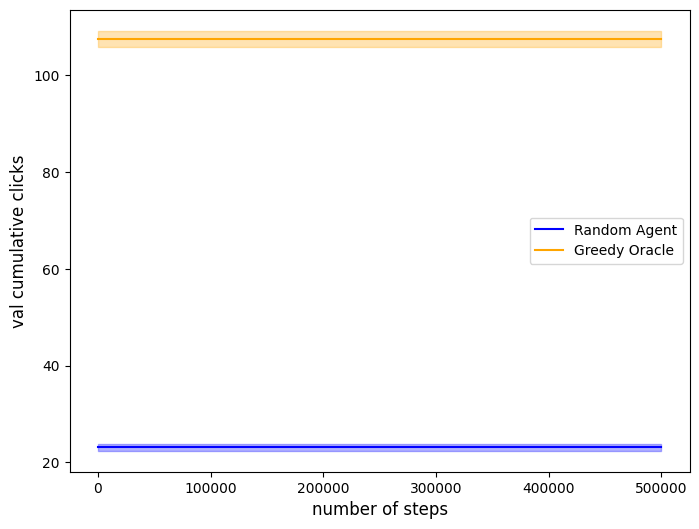

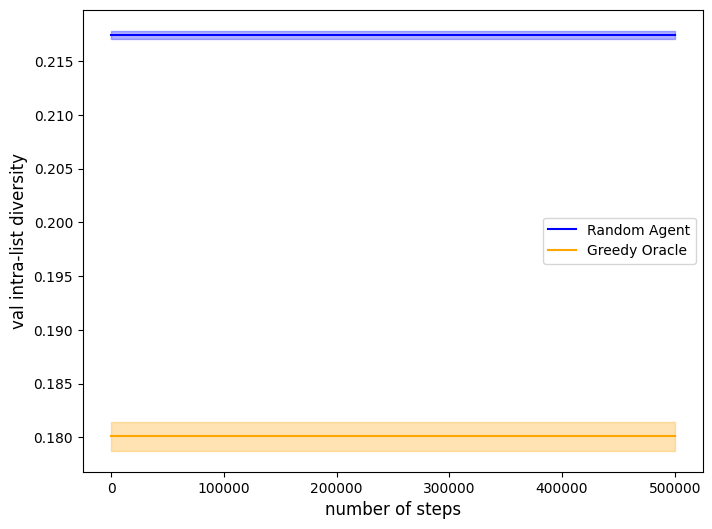

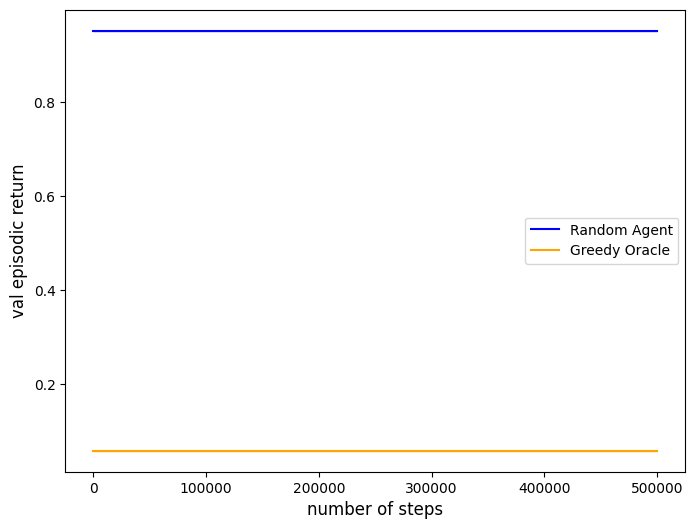

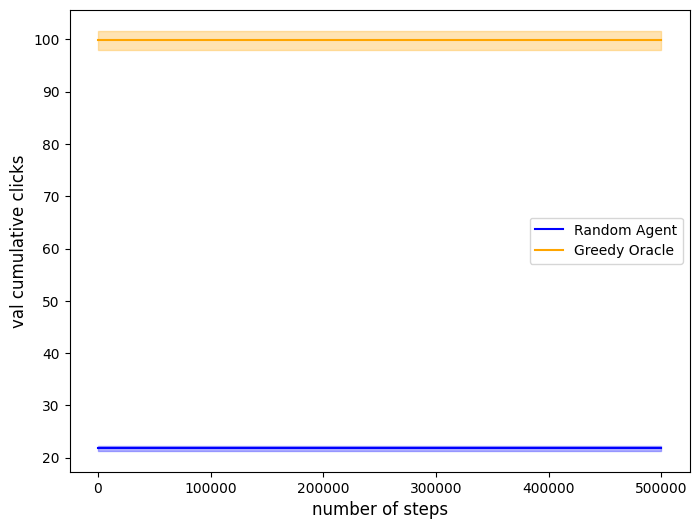

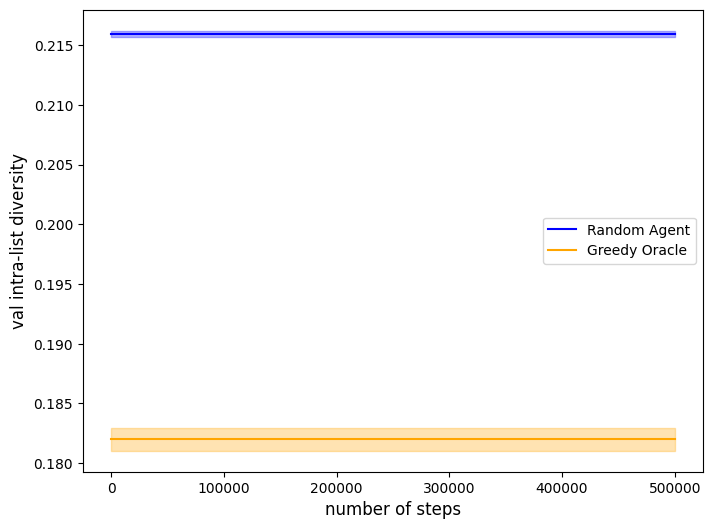

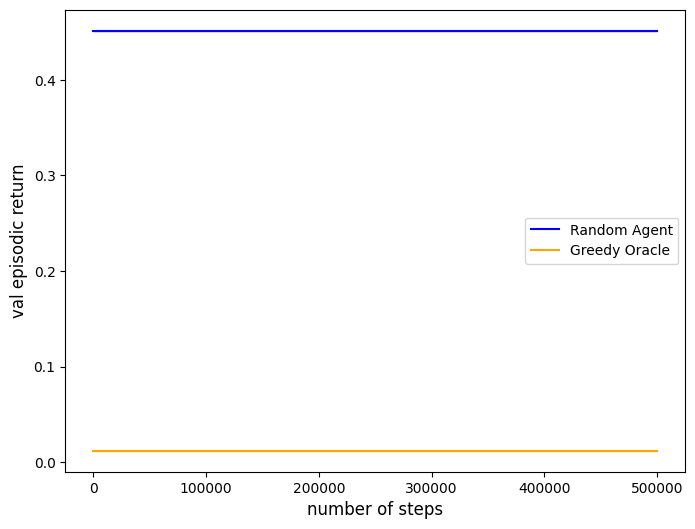

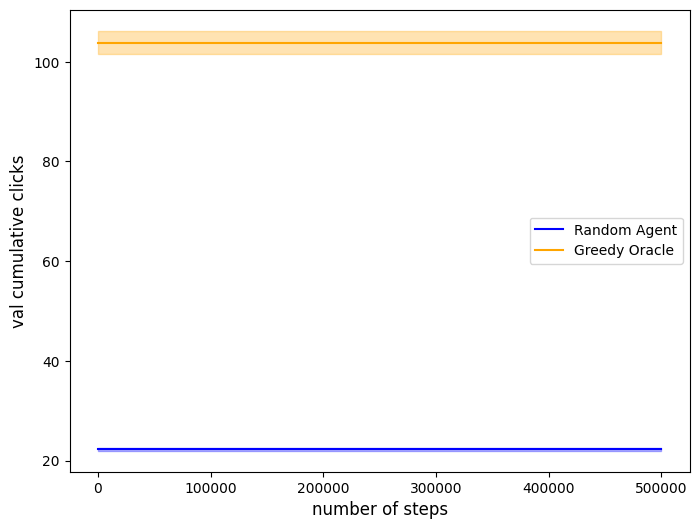

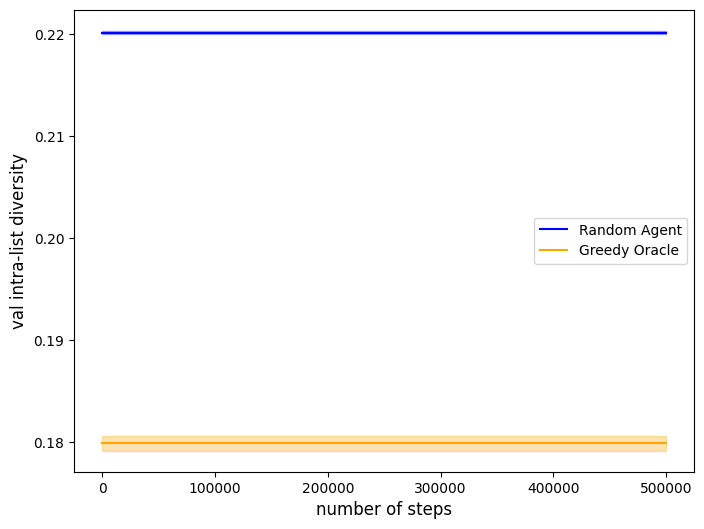

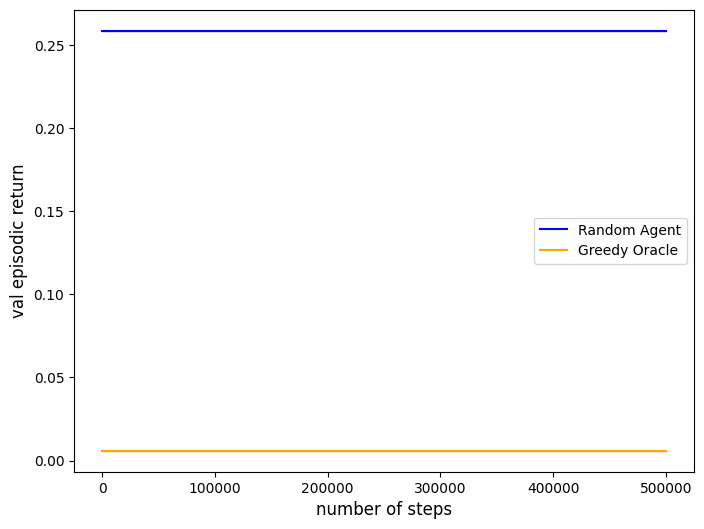

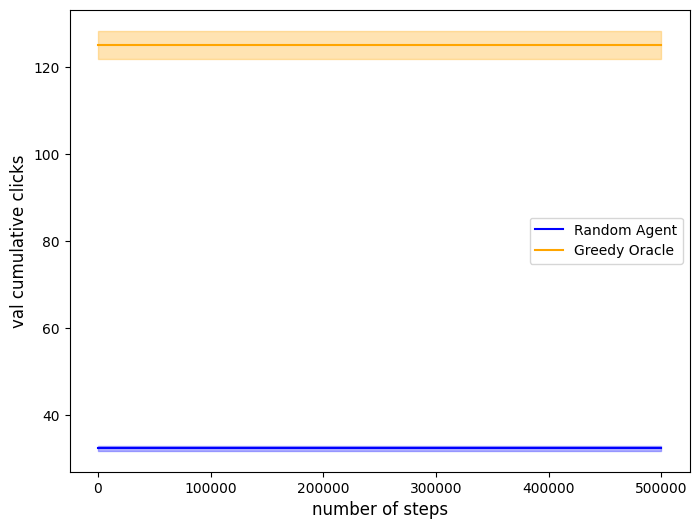

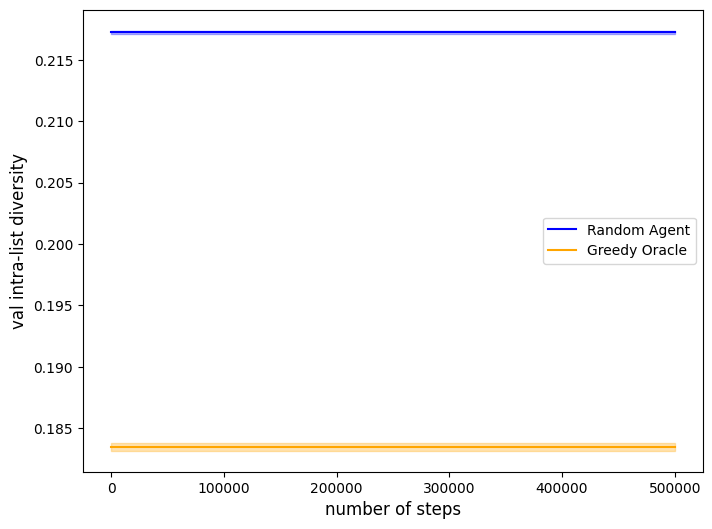

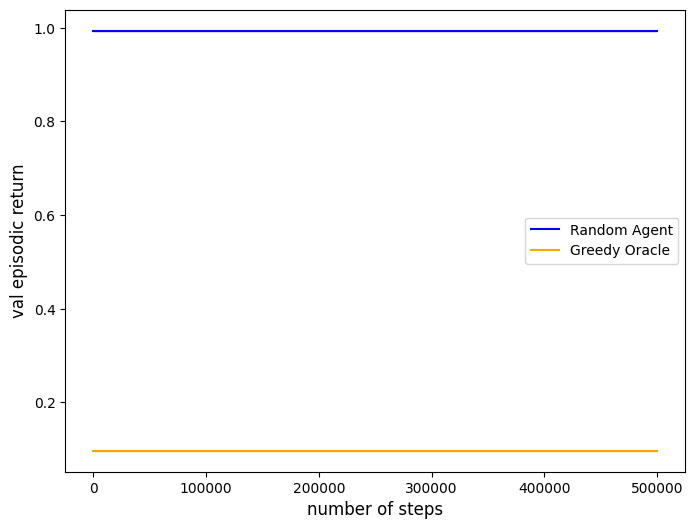

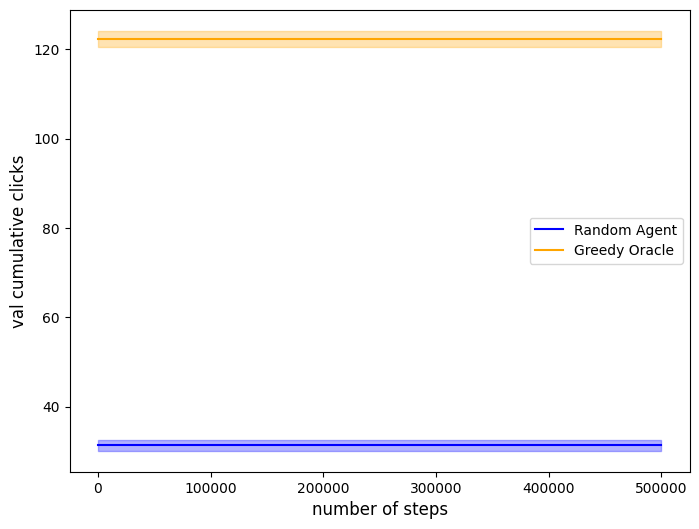

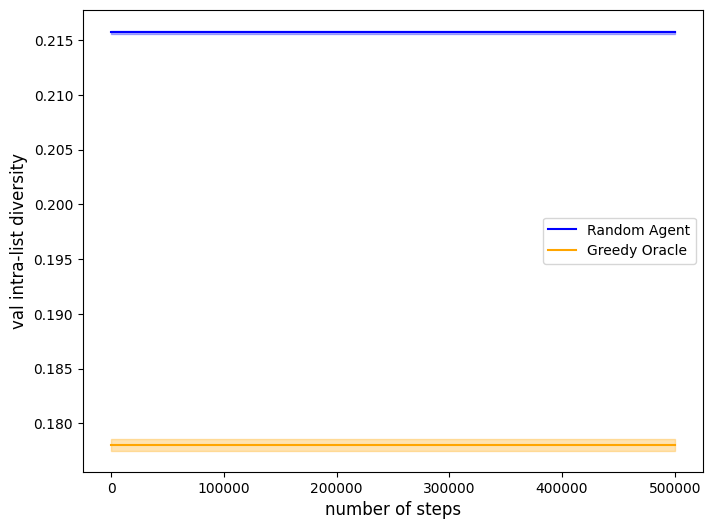

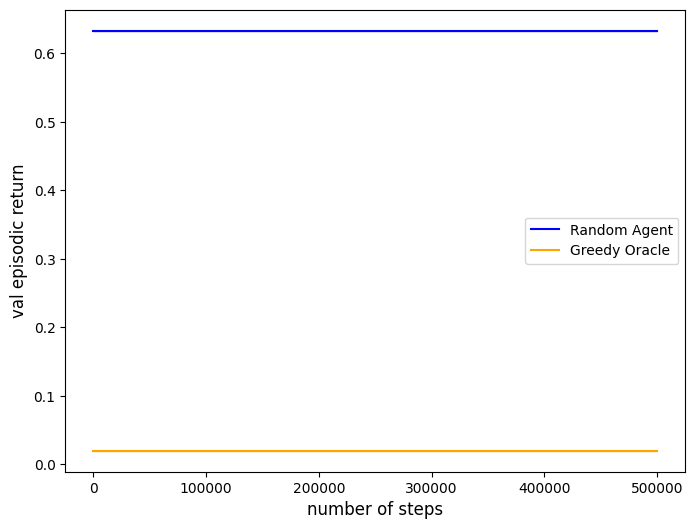

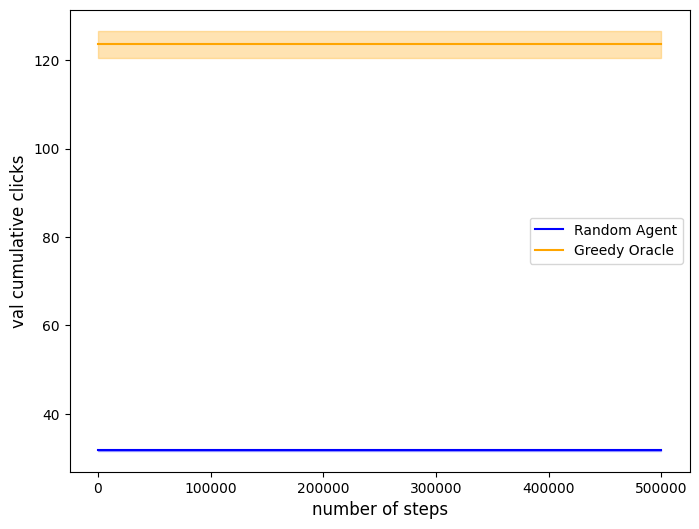

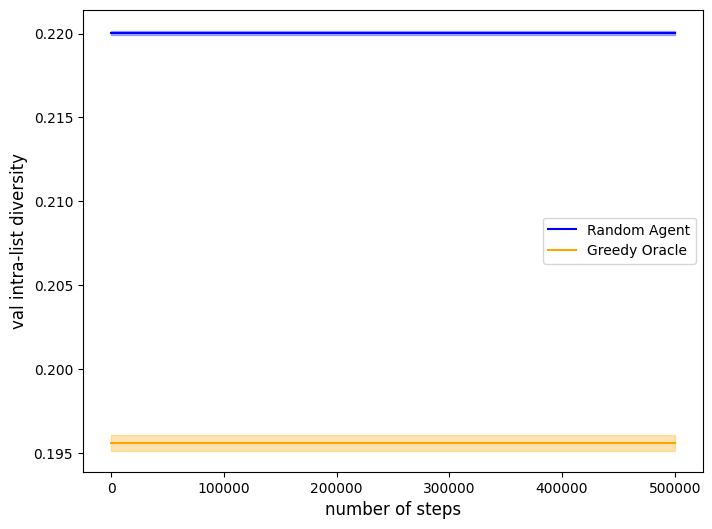

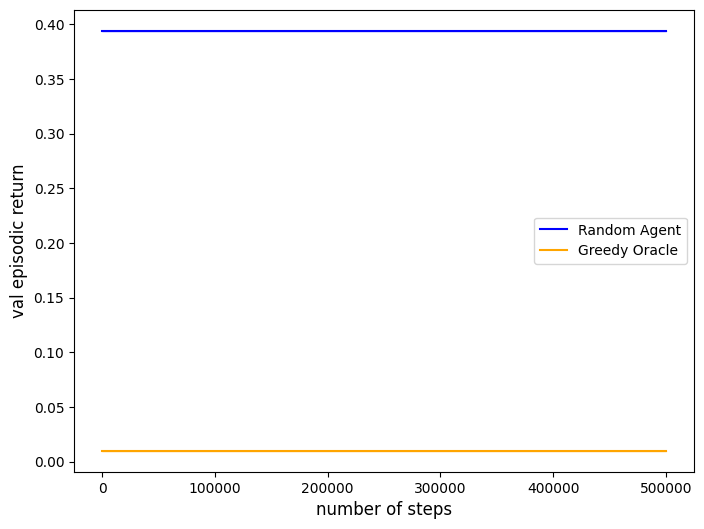

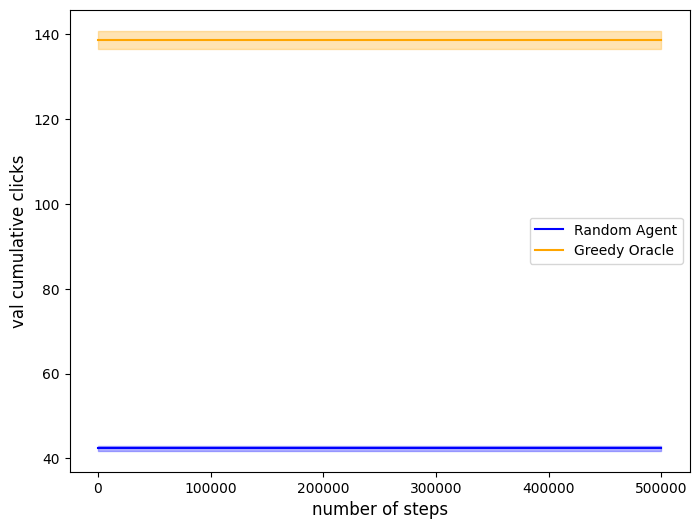

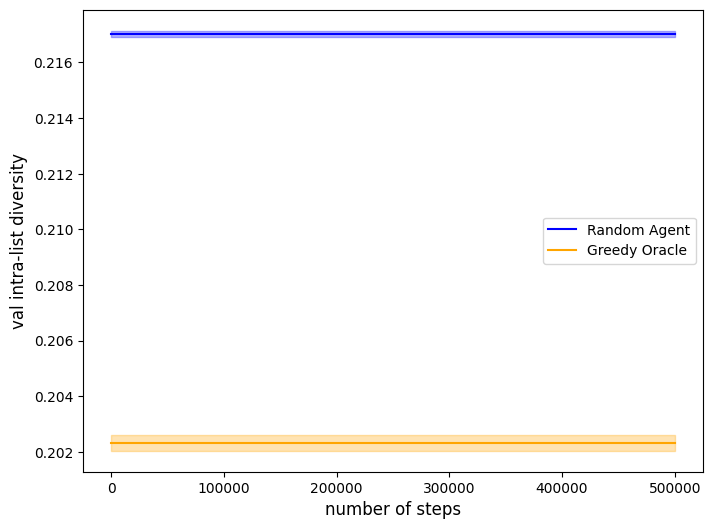

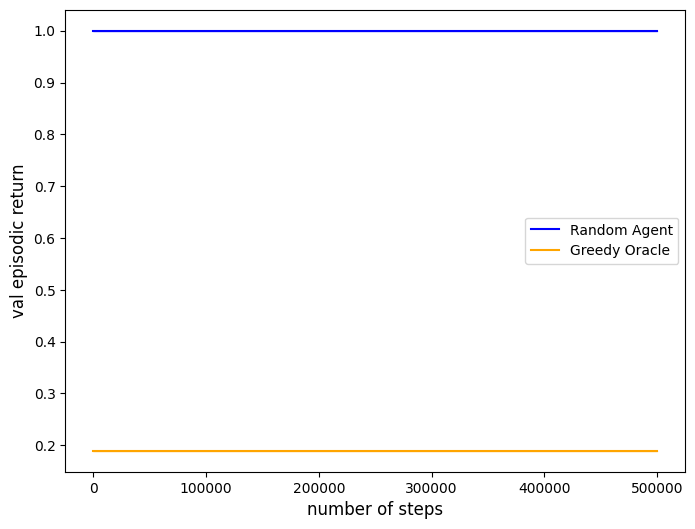

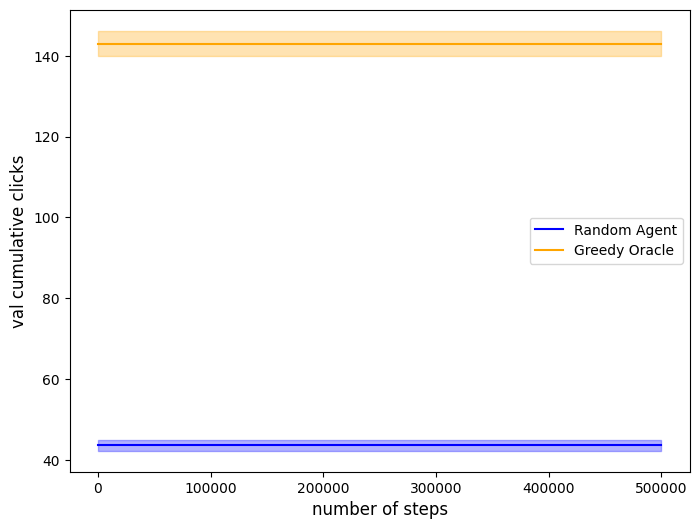

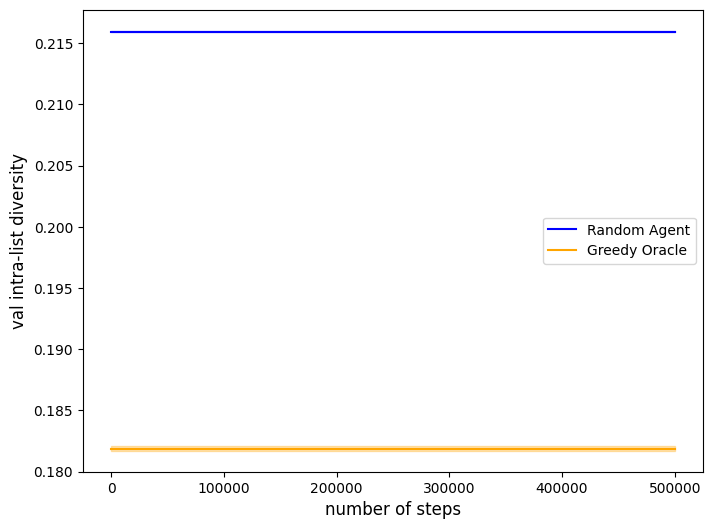

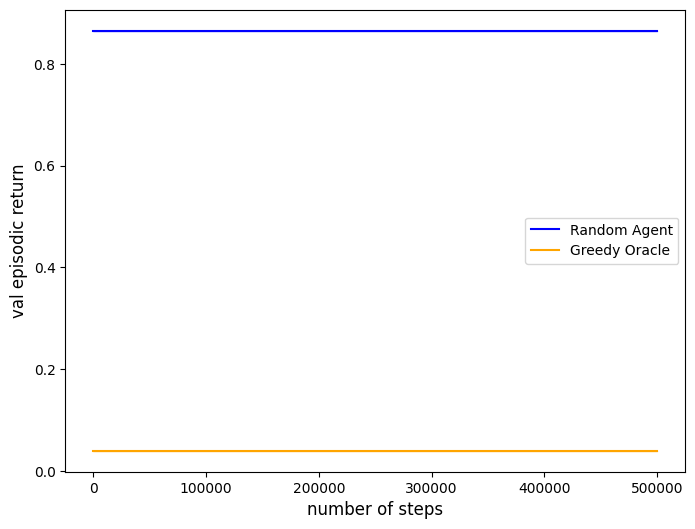

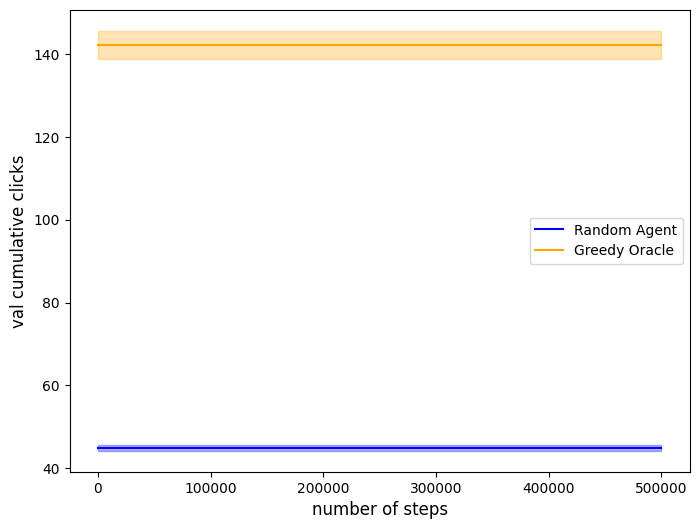

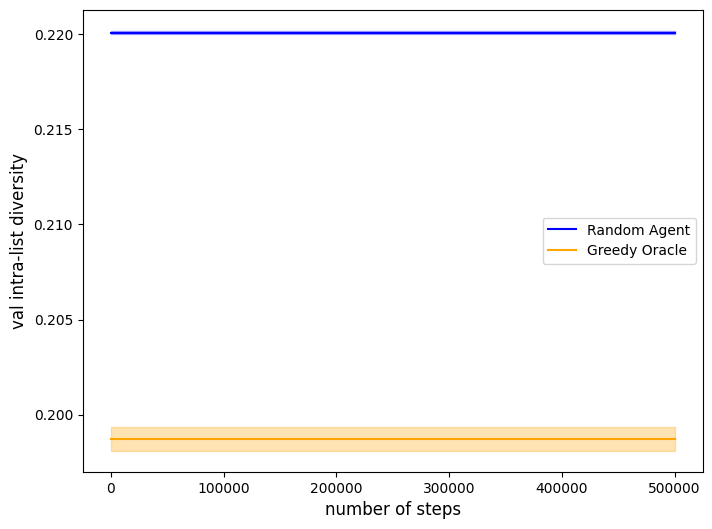

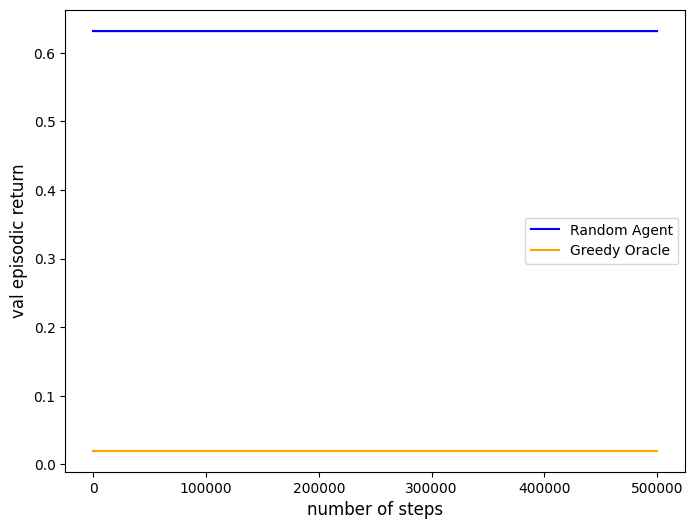

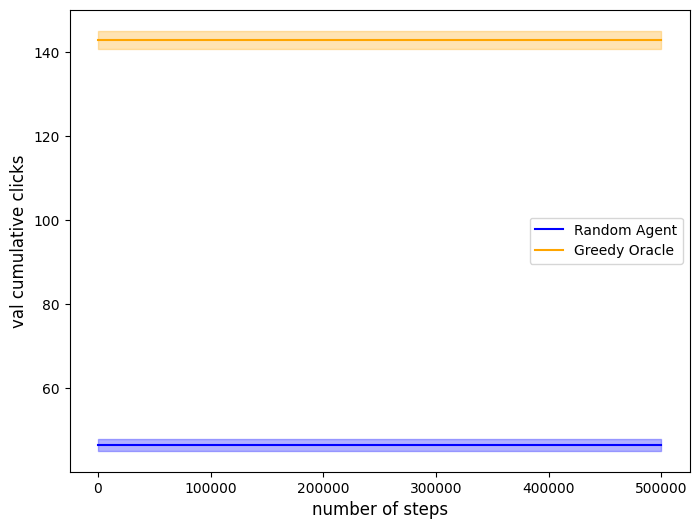

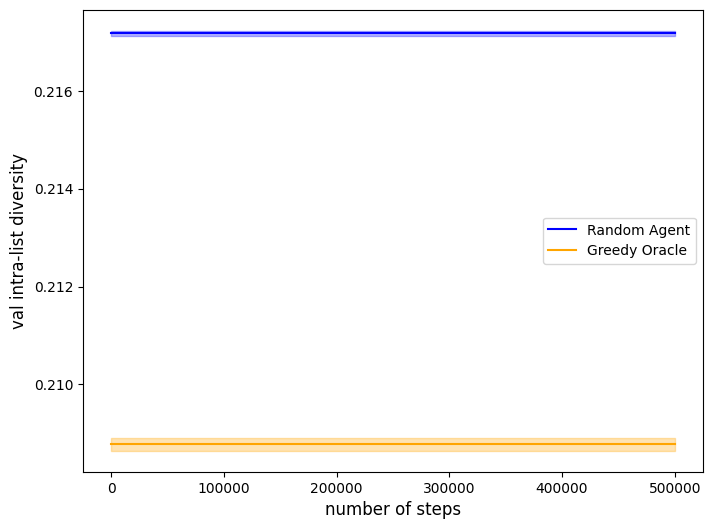

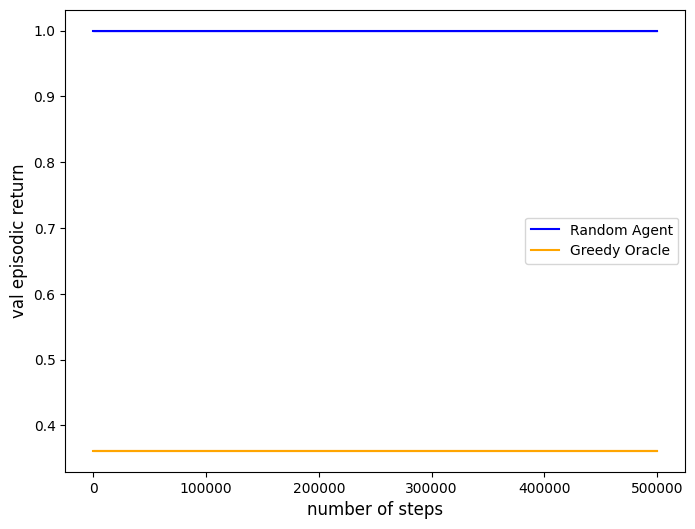

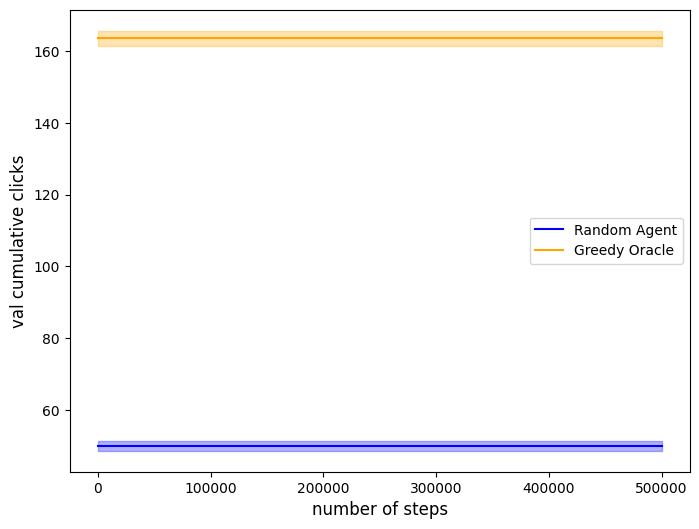

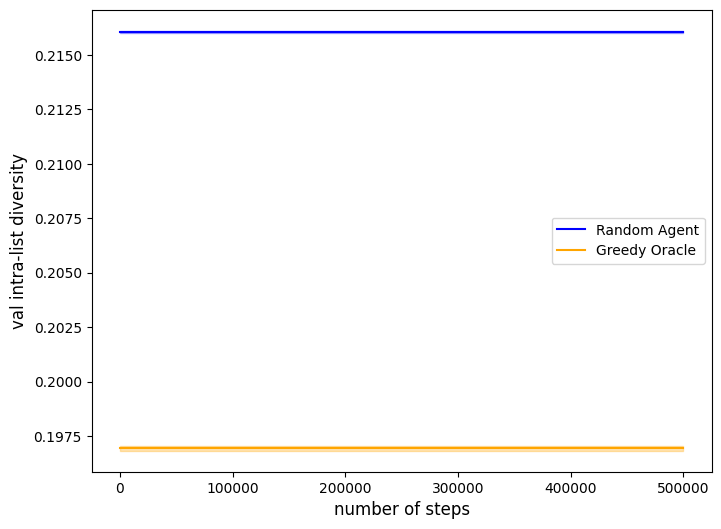

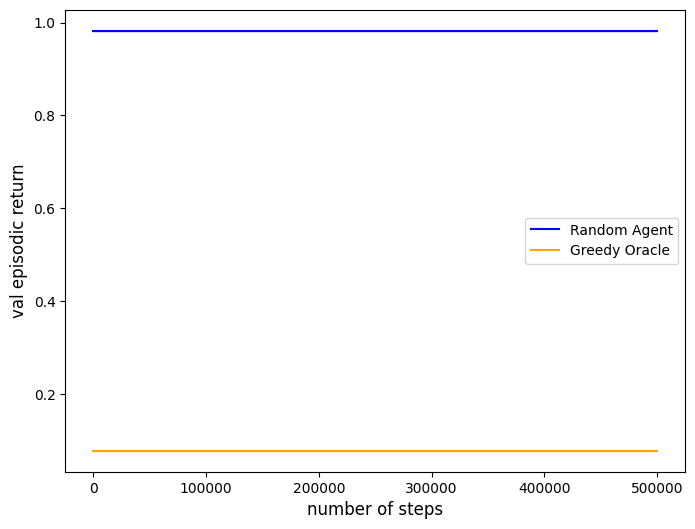

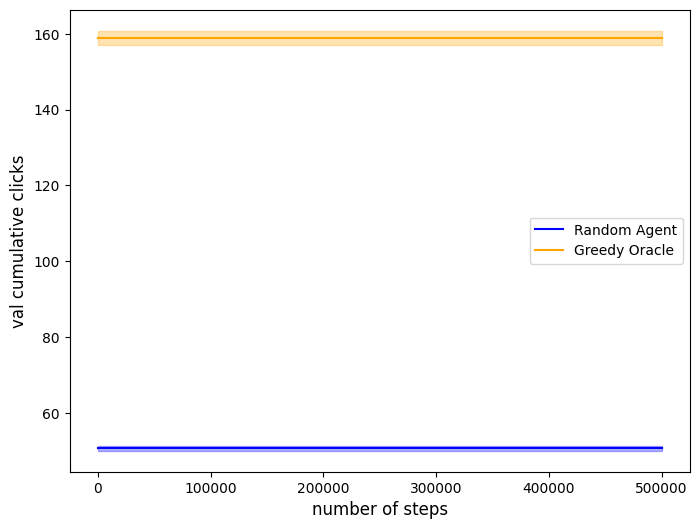

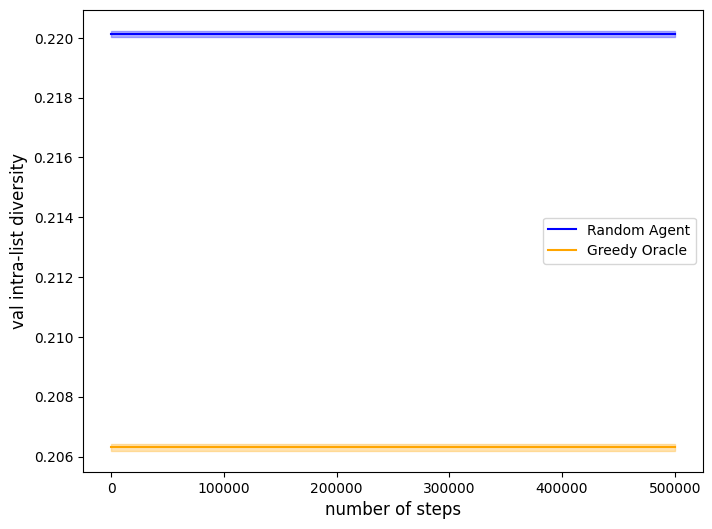

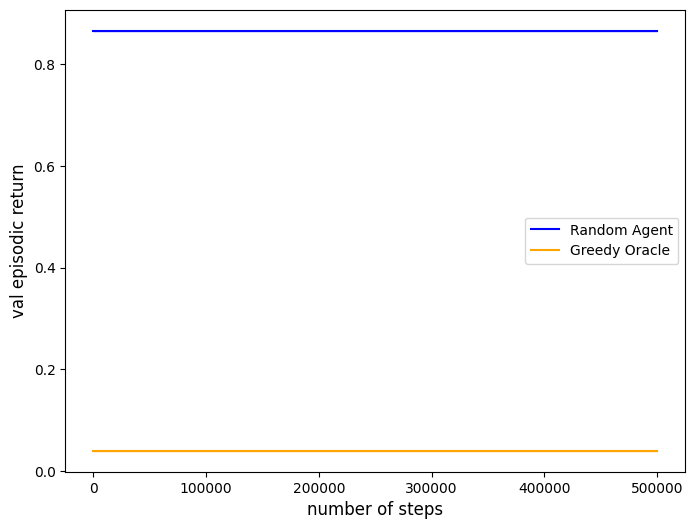

In [117]:
slate_sizes = [3, 5, 10, 20]
num_itemss = [100, 500, 1000]
env_id = "SlateTopK-Bored-v0"

os.makedirs("plots", exist_ok=True)
for slate_size in slate_sizes:
    file_path_slate_size = os.path.join("plots", f"slatesize{slate_size}")
    os.makedirs(file_path_slate_size, exist_ok=True)
    for num_items in num_itemss:
        os.makedirs(os.path.join(file_path_slate_size, f"numitems{num_items}"), exist_ok=True)
        file_path = os.path.join(file_path_slate_size, f"numitems{num_items}")
        make_plot(slate_size, num_items, "clicks", file_path, env_id)
        make_plot(slate_size, num_items, "diversity", file_path, env_id)
        make_plot(slate_size, num_items, "catalog_coverage", file_path, env_id)

In [118]:
slate_size1 = 10
slate_size2 = 3
num_items1 = 1000
num_items2 = 1000

method = "random"

clicks_random1 = df[(df["method"]=="random") & (df["slate_size"]==slate_size1) & (df["num_items"]==num_items1)]["clicks"].values[0]
clicks_random1_err = df[(df["method"]=="random") & (df["slate_size"]==slate_size1) & (df["num_items"]==num_items1)]["clicks standard error"].values[0]

clicks_greedy1 = df[(df["method"]=="greedyoracle") & (df["slate_size"]==slate_size1) & (df["num_items"]==num_items1)]["clicks"].values[0]
clicks_greedy1_err = df[(df["method"]=="greedyoracle") & (df["slate_size"]==slate_size1) & (df["num_items"]==num_items1)]["clicks standard error"].values[0]

clicks_random2 = df[(df["method"]=="random") & (df["slate_size"]==slate_size2) & (df["num_items"]==num_items2)]["clicks"].values[0]
clicks_random2_err = df[(df["method"]=="random") & (df["slate_size"]==slate_size2) & (df["num_items"]==num_items2)]["clicks standard error"].values[0]

clicks_greedy2 = df[(df["method"]=="greedyoracle") & (df["slate_size"]==slate_size2) & (df["num_items"]==num_items2)]["clicks"].values[0]
clicks_greedy2_err = df[(df["method"]=="greedyoracle") & (df["slate_size"]==slate_size2) & (df["num_items"]==num_items2)]["clicks standard error"].values[0]

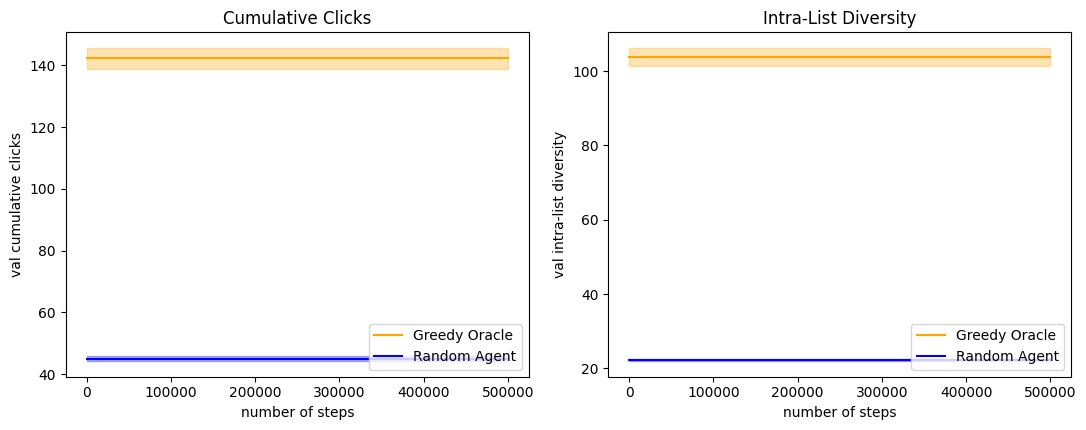

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Data example for plotting
x = np.linspace(0, 500000, 100)  # 100 steps from 0 to 500,000



# Randomly generated sample data for 2 different metrics (Random and Greedy agent)
greedy_metric1 = np.full(len(x), clicks_greedy1)  # Constant value for Greedy Oracle (Metric 1)
random_metric1 = np.full(len(x), clicks_random1)   # Constant value for Random Agent (Metric 1)

greedy_metric2 = np.full(len(x), clicks_greedy2)  # Another metric for Greedy Oracle (Metric 2)
random_metric2 = np.full(len(x), clicks_random2)   # Another metric for Random Agent (Metric 2)

# Error margins
greedy_err1 = clicks_greedy1_err
random_err1 = clicks_random1_err

greedy_err2 = clicks_greedy2_err
random_err2 = clicks_random2_err

# Create the figure with two subplots
size = 11

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(size , size*4/10))

# First subplot for Metric 1
ax1.plot(x, greedy_metric1, label="Greedy Oracle", color="orange")
ax1.fill_between(x, greedy_metric1 - greedy_err1, greedy_metric1 + greedy_err1, alpha=0.3, color="orange")
ax1.plot(x, random_metric1, label="Random Agent", color="blue")
ax1.fill_between(x, random_metric1 - random_err1, random_metric1 + random_err1, alpha=0.3, color="blue")
ax1.set_xlabel('number of steps')
ax1.set_ylabel('val cumulative clicks')
ax1.legend(loc="lower right")
ax1.set_title('Cumulative Clicks')

# Second subplot for Metric 2
ax2.plot(x, greedy_metric2, label="Greedy Oracle", color="orange")
ax2.fill_between(x, greedy_metric2 - greedy_err2, greedy_metric2 + greedy_err2, alpha=0.3, color="orange")
ax2.plot(x, random_metric2, label="Random Agent", color="blue")
ax2.fill_between(x, random_metric2 - random_err2, random_metric2 + random_err2, alpha=0.3, color="blue")
ax2.set_xlabel('number of steps')
ax2.set_ylabel('val intra-list diversity')
ax2.legend(loc="lower right")
ax2.set_title('Intra-List Diversity')

# Show plot
plt.tight_layout()
plt.show()


Subplot for slate si